In [ ]:
from google.colab import drive
 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install contractions
!pip install beautifulsoup4
!pip install gensim
!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install yellowbrick
!pip3 install truecase
!pip install ekphrasis
!pip install hyperopt
!pip install seaborn
!pip install ray[tune]
!python -m spacy download en_core_web_sm
!pip install ray

     |████████████████████████████████| 284 kB 9.0 MB/s 
     |████████████████████████████████| 321 kB 47.7 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85451 sha256=20400fd0a7306a5c37266d00eb3b0d80c2b063cc06941d5a38c6cc100ee760e4
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 1.6 MB 7.4 MB/s 
     |████████████████████████████████| 816 kB 73.6 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

     |████████████████████████████████| 5.9 MB 7.2 MB/s 
     |████████████████████████████████| 456 kB 76.7 MB/s 
     |████████████████████████████████| 42 kB 2.0 MB/s 
     |████████████████████████████████| 10.1 MB 67.2 MB/s 
     |████████████████████████████████| 623 kB 66.3 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 28.4 MB 98 kB/s 
     |████████████████████████████████| 80 kB 5

In [ ]:
from preprocessor import Preprocessor
from data_understanding import DataUnderstanding
from lstm import TweetClassifier, AccountClassifier
from dataset_loader import DatasetMaper, DataSetLoader, DatasetMaperList
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, confusion_matrix
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from keras.preprocessing import sequence
import gensim.models.fasttext as fasttext
import pickle
import pandas as pd
import numpy as np
import dataset_loader
from hyperopt import fmin, tpe, hp
from functools import partial
from pathlib import Path
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler
from ray import tune
import ray
from optimizer import Optimizer

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
RUN_ON_SERVER = True
LOAD_PREPROCESSED_DATA = True
LOAD_TRAINED_CLASSIFIER = False

if RUN_ON_SERVER:
    test_path = '/data/test/en/'
    train_path = '/data/training/en/'
    glove_path = "gdrive/MyDrive/Data/glove.twitter.27B/glove.twitter.27B.50d.txt"
    glove_out = 'emb_word2vec_format.txt'
    #glove_out = 'emb_word2vec_format.txt'
else:
    test_path = '../Data/test/en/'
    train_path = '../Data/training/en/'
    glove_path = '../Data/glove.twitter.27B/glove.twitter.27B.50d.txt'
    glove_out = '../Glove/emb_word2vec_format.txt'
    
earlybird_path = '../Data/earlybird/en/'

TWEET_LENGTH = 40
VOCABULARY_SIZE = 2000
LEARNING_RATE = 0.001
BATCH_SIZE = 64
ACCOUNT_TWEETS_NUMBER = 100
DATA_UNDERSTANDING_ENABLED = False
EMBEDDING_DIM = 50
tweet_classifier_path = 'tweet_classifier'
account_classifier_path = 'account_classifier'

In [ ]:
def evaulate(y_pred, y):
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    print(f'Accuracy: {acc}')
    print(f'F1 Score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    
    print("Classification Report:")
    print(classification_report(y, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    return f1
    
def get_tweet_based_account_prediction(x, y, classifier):
    accounts_pred = []
    accounts_probabilities = []
    accounts_hidden_states = []
    y_tweets = []
    y_tweets_probabilities = []
    i = 0
    for accounts in x:
        proccessed_percante = i/len(x)*100
        if i%100 == 0:
            print(f'Predicted {proccessed_percante}% of accounts')
        y_account = [y[i]]*len(accounts)    
        #y_pred, h = classifier.get_prediction(classifier, accounts, y_account)
        y_pred, h, y_probabilites, _ = classifier.get_prediction(accounts, y_account)
        accounts_pred.append(y_pred)
        accounts_probabilities.append(y_probabilites)
        y_tweets.extend(y_pred)
        accounts_hidden_states.append(h)
        i += 1
    return accounts_pred, accounts_hidden_states, y_tweets, accounts_probabilities

def get_majority_vote_for_account(account):
    number_of_bots = sum(account)
    return 1 if number_of_bots >= 50 else 0
    
def get_majority_vote(accounts):
    votes = []
    for account in accounts:
        votes.append(get_majority_vote_for_account(account))
    return votes

def write_to_file(data, name):
    output = open(name+'.pkl', 'wb')
    pickle.dump(data, output)

def get_from_file(name):
    pkl_file = open(name +'.pkl', 'rb')
    return pickle.load(pkl_file)

def save_preprocessed_data(x_test, y_test, x, y, x_val, y_val, hashes_val, hashes_test, hashes_train):
    print('Saving preprocessed data to Files')
    Path('serialization').mkdir(parents=True, exist_ok=True)
    write_to_file(x_test, 'serialization/x_test')
    write_to_file(y_test, 'serialization/y_test')
    write_to_file(x, 'serialization/x')
    write_to_file(y, 'serialization/y')
    write_to_file(x_val, 'serialization/x_val')
    write_to_file(y_val, 'serialization/y_val')
    
    write_to_file(hashes_test, 'serialization/hashes_test')
    write_to_file(hashes_train, 'serialization/hashes_train')
    write_to_file(hashes_val, 'serialization/hashes_val')


In [ ]:
data_understander = DataUnderstanding()
preprocessor = Preprocessor()
dataset_loader = DataSetLoader(train_path)

In [ ]:
glove2word2vec(glove_input_file=glove_path, word2vec_output_file=glove_out)
embedding = gensim.models.KeyedVectors.load_word2vec_format(glove_out)


In [ ]:
if LOAD_PREPROCESSED_DATA:
    print('Getting serailized data\n')
    x_test = get_from_file('x_test')
    y_test = get_from_file('y_test')
    x = get_from_file('x')
    y = get_from_file('y')
    x_val = get_from_file('x_val')
    y_val = get_from_file('y_val')
    hashes_test = get_from_file('hashes_test')
    hashes_train = get_from_file('hashes_train')
    hashes_val = get_from_file('hashes_val')
    
    #x, y, x_train, y_train, x_val, y_val, x_padded_train, x_padded_val, x_tweets_train, y_tweets_train, x_tweets_val, y_tweets_val = dataset_loader.get_all_data_from_x_y(x ,y, embedding)
    x_test, y_test, x_padded_test, x_tweets_test, y_tweets_test = dataset_loader.get_all_data_from_x_y(x_test, y_test, embedding, shouldSplit=False)
    x_train, y_train, x_padded_train, x_tweets_train, y_tweets_train = dataset_loader.get_all_data_from_x_y(x, y, embedding, shouldSplit=False)
    x_val, y_val, x_padded_val, x_tweets_val, y_tweets_val = dataset_loader.get_all_data_from_x_y(x_val, y_val, embedding, shouldSplit=False)
else:
    print('Getting training and test set')
    #x, y, x_train, y_train, x_val, y_val, x_padded_train, x_padded_val, x_tweets_train, y_tweets_train, x_tweets_val, y_tweets_val, hashes_train = dataset_loader.get_all_x_y(earlybird_path, embedding)
    x_test, y_test, x_padded_test, x_tweets_test, y_tweets_test, hashes_test = dataset_loader.get_all_x_y(test_path, embedding, shouldSplit=False)
    x_train, y_train, x_padded_train, x_tweets_train, y_tweets_train, hashes_train = dataset_loader.get_all_x_y(train_path, embedding, truth='truth-train.txt', shouldSplit=False)
    x_val, y_val, x_padded_val, x_tweets_val, y_tweets_val, hashes_val = dataset_loader.get_all_x_y(train_path, embedding, truth='truth-dev.txt', shouldSplit=False)

    save_preprocessed_data(x_test, y_test, x_train, y_train, x_val, y_val, hashes_val, hashes_test, hashes_train)

Getting serailized data



In [ ]:
tweet_classifier = torch.load('gdrive/MyDrive/Data/tweet_classifier')

In [ ]:
print('\nTraining set')
tweet_based_accounts_train_pred, accounts_h_train, y_tweets_pred, tweet_based_account_train_probabilites = get_tweet_based_account_prediction(x_padded_train, y_train, tweet_classifier)

account_majority_vote_train = get_majority_vote(tweet_based_accounts_train_pred)
account_probability_vote_train = get_majority_vote(tweet_based_account_train_probabilites)

print('\nEvaulation of Tweet Prediction')
evaulate(y_tweets_pred, y_tweets_train)
evaulate(account_majority_vote_train, y_train)
evaulate(account_probability_vote_train, y_train)

print('\Test set:')
tweet_based_accounts_pred_test, accounts_h_test, y_tweets_test_pred, tweet_based_account_probabilites_test = get_tweet_based_account_prediction(x_padded_test, y_test, tweet_classifier)

account_majority_vote_test = get_majority_vote(tweet_based_accounts_pred_test)
account_probability_vote_test = get_majority_vote(tweet_based_account_probabilites_test)

print('\nEvaulation of Tweet Prediction')
evaulate(y_tweets_test_pred, y_tweets_test)
evaulate(account_majority_vote_test, y_test)
evaulate(account_probability_vote_test, y_test)

print('\nValidation Set:')
tweet_based_accounts_val_pred, accounts_h_val, y_tweets_val_pred, tweet_based_account_probabilites_val = get_tweet_based_account_prediction(x_padded_val, y_val, tweet_classifier)
evaulate(y_tweets_val_pred, y_tweets_val)


Training set
Predicted 0.0% of accounts
Predicted 3.4722222222222223% of accounts
Predicted 6.944444444444445% of accounts
Predicted 10.416666666666668% of accounts
Predicted 13.88888888888889% of accounts
Predicted 17.36111111111111% of accounts
Predicted 20.833333333333336% of accounts
Predicted 24.305555555555554% of accounts
Predicted 27.77777777777778% of accounts
Predicted 31.25% of accounts
Predicted 34.72222222222222% of accounts
Predicted 38.19444444444444% of accounts
Predicted 41.66666666666667% of accounts
Predicted 45.13888888888889% of accounts
Predicted 48.61111111111111% of accounts
Predicted 52.083333333333336% of accounts
Predicted 55.55555555555556% of accounts
Predicted 59.02777777777778% of accounts
Predicted 62.5% of accounts
Predicted 65.97222222222221% of accounts
Predicted 69.44444444444444% of accounts
Predicted 72.91666666666666% of accounts
Predicted 76.38888888888889% of accounts
Predicted 79.86111111111111% of accounts
Predicted 83.33333333333334% of acco

0.7373635794124436

In [ ]:
print('\Test set:')
tweet_based_accounts_pred_test, accounts_h_test, y_tweets_test_pred, tweet_based_account_probabilites_test = get_tweet_based_account_prediction(x_padded_test, y_test, tweet_classifier)

account_majority_vote_test = get_majority_vote(tweet_based_accounts_pred_test)
account_probability_vote_test = get_majority_vote(tweet_based_account_probabilites_test)

print('\nEvaulation of Tweet Prediction')
evaulate(y_tweets_test_pred, y_tweets_test)
evaulate(account_majority_vote_test, y_test)
evaulate(account_probability_vote_test, y_test)

\Test set:
Predicted 0.0% of accounts
Predicted 3.787878787878788% of accounts
Predicted 7.575757575757576% of accounts
Predicted 11.363636363636363% of accounts
Predicted 15.151515151515152% of accounts
Predicted 18.939393939393938% of accounts
Predicted 22.727272727272727% of accounts
Predicted 26.515151515151516% of accounts
Predicted 30.303030303030305% of accounts
Predicted 34.090909090909086% of accounts
Predicted 37.878787878787875% of accounts
Predicted 41.66666666666667% of accounts
Predicted 45.45454545454545% of accounts
Predicted 49.24242424242424% of accounts
Predicted 53.03030303030303% of accounts
Predicted 56.81818181818182% of accounts
Predicted 60.60606060606061% of accounts
Predicted 64.39393939393939% of accounts
Predicted 68.18181818181817% of accounts
Predicted 71.96969696969697% of accounts
Predicted 75.75757575757575% of accounts
Predicted 79.54545454545455% of accounts
Predicted 83.33333333333334% of accounts
Predicted 87.12121212121212% of accounts
Predicted 9

0.8697768762677485

In [ ]:
x_tweets_test_without_preprocess = get_from_file('x_tweet_test_without_prep')

In [ ]:
incorrect_y = []
incorrect_tweet_preproccessed = []
incorrect_tweet_withotut_preproccessed = []
for i in range(0, len(y_tweets_test)):
  if y_tweets_test[i] != y_tweets_test_pred:
    incorrect_y.append(y_tweets_test[i])
    incorrect_tweet_withotut_preproccessed.append(x_tweets_test_without_preprocess[i])
    incorrect_tweet_preproccessed.append(x_test[int(i/100)][i%100])

In [ ]:
for i in range(220000,220099):
  print(incorrect_tweet_withotut_preproccessed[i])
  print(incorrect_tweet_preproccessed[i])
  print(incorrect_y[i])
  print("---------------")

A quote on Edinburgh “It is quite lovely – bits of it.” Oscar Wilde - Oh well cannot win then all.
a quote on edinburgh it is quite lovely bits of it . oscar wilde - oh well cannot win then all .
0
---------------
RT @SethMacFarlane: Oprah is beyond doubt a magnificent orator. But the idea of a reality show star running against a talk show host is tro…
rt <user> : oprah is beyond doubt a magnificent orator . but the idea of a reality show star running against a talk show host is tro . <repeat>
0
---------------
RT @CllrChasBooth: Great meeting of @LeithChooses steering group. Local £ for local projects in #Leith. Deadline 31 January for application…
rt <user> : great meeting of <user> steering group . local for local projects in <hashtag> leith . deadline <number> january for application . <repeat>
0
---------------
RT @wrobinson101: Equal pay for equal work - it's the law - as Carrie says. See her letter@the times #carriegracie #IStandWithCarrie #Equal…
rt <user> : equal pay for equal

In [ ]:
df_train, accounts_h_train_norm = preprocessor.scale_hidden_states(accounts_h_train)
df_val, accounts_h_val_norm = preprocessor.scale_hidden_states(accounts_h_val, should_fit=False)
df_test, accounts_h_test_norm = preprocessor.scale_hidden_states(accounts_h_test, should_fit=False)

In [ ]:
from ray import tune
from ray.tune.suggest.hyperopt import HyperOptSearch
from lstm import TweetClassifier, AccountClassifier
from ray.tune import CLIReporter
from ray.tune.schedulers import AsyncHyperBandScheduler

def create_account_classifier(space, x_train, y_train, x_val, y_val, lengths, epochs=100):
    name = 'Tweet_Classifier_' + str(space['batch_size']) +'_' + str(space['lstm_layers'])  +'_' + str(space['lr']) +'_' + str(space['lstm_hidden_size'])
    account_classifier = AccountClassifier(input_size=space['input_size'],
                                      batch_size = space['batch_size'],
                                      lstm_layers = space['lstm_layers'],
                                      lr=space['lr'],
                                      lstm_hidden_size=space['lstm_hidden_size'],
                                      bidirectional = True,
                                      weight_decay = space['weight_decay'],
                                      lstm_dropout = space['lstm_dropout'],
                                      fc_drouput = space['fc_drouput'],
                                      nn_size = space['nn_layers'], 
                                      optimize = True)
                
    account_classifier.train_model(x_train, y_train, x_val, lengths, y_val, epochs=epochs)


def create_model(space, embedding, x_tweets_train, y_tweets_train, x_tweets_val, y_tweets_val, epochs=10):
    name = 'Accoutn_Classifier_' + str(space['batch_size']) +'_' + str(space['lstm_layers'])  +'_' + str(space['lr']) +'_' + str(space['lstm_hidden_size'])
    tweet_classifier = TweetClassifier(input_size=1000,
                                      embedding_dim = 50,
                                      batch_size = space['batch_size'],
                                      lstm_layers = space['lstm_layers'],
                                      preprocessor=0,
                                      lr=space['lr'],
                                      lstm_hidden_size=space['lstm_hidden_size'],
                                      pretrained_model = embedding,
                                      bidirectional = True,
                                      weight_decay = space['weight_decay'],
                                      lstm_dropout = space['lstm_dropout'],
                                      fc_drouput = space['fc_drouput'],
                                      nn_size = space['nn_layers'], 
                                      optimize = True,
                                      name=name)
                
    tweet_classifier.train_model(x_tweets_train, y_tweets_train, x_tweets_val, y_tweets_val, epochs=epochs)
    
    
class Optimizer():
    def __init__(self, x_train, y_train, x_val,
                 y_val, embedding, 
                 preprocessor, vocab = 10000,
                 embedding_dim=50, epochs=20):
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.embedding_dim = embedding_dim
        self.preprocessor = preprocessor
        self.epochs = epochs
        self.vocab = vocab
        self.embedding = embedding
        
    def optimize(self, space, current_best_params, trials, lengths=0, optimizeTweetClassifier=True):
        search_alg = HyperOptSearch(
            space,
            metric="val_acc",
            mode="max",
            points_to_evaluate = current_best_params)
        
        scheduler = AsyncHyperBandScheduler(
              time_attr='iterations',
              metric="val_acc",
              mode="max",
              reduction_factor=2,
              brackets=200,
              grace_period=100)

        if optimizeTweetClassifier:
            analysis = tune.run(
                tune.with_parameters(create_model, 
                                     embedding=self.embedding,
                                     x_tweets_train=self.x_tweets_train,
                                     y_tweets_train = self.y_tweets_train, 
                                     x_tweets_val = self.x_tweets_val,
                                     y_tweets_val = self.y_tweets_val, 
                                     epochs=self.epochs),
                search_alg=search_alg, 
                scheduler=scheduler,
                num_samples=trials,
                resources_per_trial={"cpu": 2, "gpu": 1}
                )
        else:
            analysis = tune.run(
                tune.with_parameters(create_account_classifier, 
                                     x_train=self.x_train,
                                     y_train = self.y_train, 
                                     x_val = self.x_val,
                                     y_val = self.y_val,
                                     lengths=lengths,
                                     epochs=self.epochs),
                search_alg=search_alg, 
                scheduler=scheduler,
                num_samples=trials,
                resources_per_trial={"cpu": 2, "gpu": 1}
                )
            

        print("Best config: ", analysis.get_best_config(
            metric="val_acc", mode="max"))
        
        # Get a dataframe for analyzing trial results.
        df = analysis.trial_dataframes
        return analysis, df
          #ray.shutdown()

In [ ]:
    optimizer = Optimizer(x_train=accounts_h_train_norm, y_train=y_train, x_val=accounts_h_val_norm,
                 y_val=y_val, embedding=embedding, 
                 preprocessor=0, vocab = 10000,
                 embedding_dim=50, epochs=100)

In [ ]:
space = {
    'input_size': hp.choice('input_size', [32]),
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.2)),
    'lstm_hidden_size': hp.choice('lstm_hidden_size', [32, 64, 128, 256]),
    'lstm_layers': hp.choice('lstm_layers', [1, 2]),
    'batch_size': hp.choice('batch_size', [32, 64]),
    'nn_layers': hp.choice('nn_layers', [32, 64, 128, 256]),
    'lstm_dropout': hp.uniform('lstm_dropout', 0.0, 0.5),
    'fc_drouput': hp.uniform('fc_drouput', 0.0, 0.5),
    'weight_decay': hp.uniform('weight_decay', 0.0, 0.1)
    }
current_best_params = [
{
    'input_size': 32,
    'lr': 0.001,
    'lstm_hidden_size': 32,
    'lstm_layers': 2,
    'batch_size': 64,
    'nn_layers': 128,
    'lstm_dropout':0,
    'fc_drouput':0,
    'weight_decay': 0
}]
lengths = [100] *len(x_train)
analysis, dataframe = optimizer.optimize(space, current_best_params, trials = 30, optimizeTweetClassifier=False, lengths=lengths_norm)

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay
create_account_classifier_87920cf4,RUNNING,,64,0,32,0.001,0,32,2,128,0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay
create_account_classifier_87920cf4,RUNNING,,64,0,32,0.001,0,32,2,128,0
create_account_classifier_87a83128,PENDING,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962


(pid=10166) 2021-05-25 19:29:36.991411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=10166) Reading twitter - 1grams ...
(pid=10166) Reading twitter - 2grams ...


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay
create_account_classifier_87920cf4,RUNNING,,64,0,32,0.001,0,32,2,128,0
create_account_classifier_87a83128,PENDING,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962


(pid=10166) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10166)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10166) Using GPU...
(pid=10166) AccountClassifier(
(pid=10166)   (lstm): LSTM(32, 32, num_layers=2, bidirectional=True)
(pid=10166)   (fc1): Linear(in_features=64, out_features=128, bias=True)
(pid=10166)   (fc2): Linear(in_features=128, out_features=1, bias=True)
(pid=10166)   (dropout): Dropout(p=0.0, inplace=False)
(pid=10166) )
(pid=10166) Using GPU...
(pid=10166) Starting to train the model
(pid=10166) Training epoch 0
Result for create_account_classifier_87920cf4:
  date: 2021-05-25_19-30-03
  done: true
  experiment_id: 089ecaea9ad440748f395a706197787f
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5737771689711559
  neg_mean_loss: -0.5737771689711559
  node_ip: 172.28.0.2
  pid: 10166
  time_since_restore: 14.36340880393982
  time_this_iter_s: 14.36340880393982
  time_total_s: 14.36340880393982
  timestamp: 1621971003
  timesteps_since_restore: 0
  train_acc: 0.6315972222222223
  train_loss: 0.6376998722553253
  training_iteration: 

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_87a83128,PENDING,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_87a83128,RUNNING,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,,,,,,
create_account_classifier_9a928fae,PENDING,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597


(pid=10266) 2021-05-25 19:30:13.412925: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_87a83128,RUNNING,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,,,,,,
create_account_classifier_9a928fae,PENDING,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597


(pid=10266) Reading twitter - 1grams ...
(pid=10266) Reading twitter - 2grams ...


(pid=10266) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10266)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10266) Using GPU...
(pid=10266) AccountClassifier(
(pid=10266)   (lstm): LSTM(32, 32, num_layers=2, dropout=0.4036118825194289, bidirectional=True)
(pid=10266)   (fc1): Linear(in_features=64, out_features=256, bias=True)
(pid=10266)   (fc2): Linear(in_features=256, out_features=1, bias=True)
(pid=10266)   (dropout): Dropout(p=0.4374839749762393, inplace=False)
(pid=10266) )
(pid=10266) Using GPU...
(pid=10266) Starting to train the model
(pid=10266) Training epoch 0
Result for create_account_classifier_87a83128:
  date: 2021-05-25_19-30-42
  done: true
  experiment_id: f0aed94f006f454aa225911bf53bd1f2
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6005794406417877
  neg_mean_loss: -0.6005794406417877
  node_ip: 172.28.0.2
  pid: 10266
  time_since_restore: 17.142988920211792
  time_this_iter_s: 17.142988920211792
  time_total_s: 17.142988920211792
  timestamp: 1621971042
  timesteps_since_restore: 0
  train_acc: 0.6364583333333333
  train_l

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_9a928fae,PENDING,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_9a928fae,RUNNING,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,,,,,,
create_account_classifier_b22c2652,PENDING,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458


(pid=10302) 2021-05-25 19:30:52.852201: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_9a928fae,RUNNING,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,,,,,,
create_account_classifier_b22c2652,PENDING,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458


(pid=10302) Reading twitter - 1grams ...
(pid=10302) Reading twitter - 2grams ...


(pid=10302) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10302)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10302) Using GPU...
(pid=10302) AccountClassifier(
(pid=10302)   (lstm): LSTM(32, 64, num_layers=2, dropout=0.07500463303339594, bidirectional=True)
(pid=10302)   (fc1): Linear(in_features=128, out_features=256, bias=True)
(pid=10302)   (fc2): Linear(in_features=256, out_features=1, bias=True)
(pid=10302)   (dropout): Dropout(p=0.1266097154225227, inplace=False)
(pid=10302) )
(pid=10302) Using GPU...
(pid=10302) Starting to train the model
(pid=10302) Training epoch 0
(pid=10302) Epoch: 0 Training loss: 0.6480169243282742 Training Accuracy 0.6194444444444445 Validation Accuracy: 0.6330645161290323, Validation loss: 0.6279058878219896
Result for create_account_classifier_9a928fae:
  date: 2021-05-25_19-31-21
  done: true
  experiment_id: 5e97d81d24af4c78bee5ec22ac1d5cf9
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6279058878219896
  neg_mean_loss: -0.6279058878219896
  node_ip: 172.28.0.2
  pid: 10302
  time_since_restore: 16.0379271507263

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_b22c2652,PENDING,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_b22c2652,RUNNING,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,,,,,,
create_account_classifier_c9248ed0,PENDING,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444


(pid=10339) 2021-05-25 19:31:31.479335: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_b22c2652,RUNNING,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,,,,,,
create_account_classifier_c9248ed0,PENDING,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444


(pid=10339) Reading twitter - 1grams ...
(pid=10339) Reading twitter - 2grams ...


(pid=10339) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10339)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10339) Using GPU...
(pid=10339) AccountClassifier(
(pid=10339)   (lstm): LSTM(32, 256, num_layers=2, dropout=0.2947717524440494, bidirectional=True)
(pid=10339)   (fc1): Linear(in_features=512, out_features=32, bias=True)
(pid=10339)   (fc2): Linear(in_features=32, out_features=1, bias=True)
(pid=10339)   (dropout): Dropout(p=0.0443015722794361, inplace=False)
(pid=10339) )
(pid=10339) Using GPU...
(pid=10339) Starting to train the model
(pid=10339) Training epoch 0
(pid=10339) Epoch: 0 Training loss: 48.90438235865699 Training Accuracy 0.5 Validation Accuracy: 0.5, Validation loss: 50.0
Result for create_account_classifier_b22c2652:
  date: 2021-05-25_19-32-01
  done: true
  experiment_id: 4067e27e51ff4a179f9739089e866264
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 50.0
  neg_mean_loss: -50.0
  node_ip: 172.28.0.2
  pid: 10339
  time_since_restore: 17.32577681541443
  time_this_iter_s: 17.32577681541443
  time_total_s: 17.32577681541443
 

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_c9248ed0,PENDING,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_c9248ed0,RUNNING,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,,,,,,
create_account_classifier_e0f5254c,PENDING,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_c9248ed0,RUNNING,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,,,,,,
create_account_classifier_e0f5254c,PENDING,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5


(pid=10378) 2021-05-25 19:32:11.696194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=10378) Reading twitter - 1grams ...
(pid=10378) Reading twitter - 2grams ...


(pid=10378) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10378)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10378) Using GPU...
(pid=10378) AccountClassifier(
(pid=10378)   (lstm): LSTM(32, 256, num_layers=2, dropout=0.45051740217393493, bidirectional=True)
(pid=10378)   (fc1): Linear(in_features=512, out_features=256, bias=True)
(pid=10378)   (fc2): Linear(in_features=256, out_features=1, bias=True)
(pid=10378)   (dropout): Dropout(p=0.36530451417578075, inplace=False)
(pid=10378) )
(pid=10378) Using GPU...
(pid=10378) Starting to train the model
(pid=10378) Training epoch 0
(pid=10378) Epoch: 0 Training loss: 0.639423108763165 Training Accuracy 0.59375 Validation Accuracy: 0.7088709677419355, Validation loss: 0.5996363513502142
Result for create_account_classifier_c9248ed0:
  date: 2021-05-25_19-32-41
  done: true
  experiment_id: dfcaf505eec24f3e8548479ac0781189
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5996363513502142
  neg_mean_loss: -0.5996363513502142
  node_ip: 172.28.0.2
  pid: 10378
  time_since_restore: 16.98155927658081
  time_t

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_e0f5254c,PENDING,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_e0f5254c,RUNNING,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,,,,,,
create_account_classifier_f8961026,PENDING,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375


(pid=10414) 2021-05-25 19:32:51.292904: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_e0f5254c,RUNNING,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,,,,,,
create_account_classifier_f8961026,PENDING,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375


(pid=10414) Reading twitter - 1grams ...
(pid=10414) Reading twitter - 2grams ...


(pid=10414) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10414)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10414) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11805969974109942 and num_layers=1
(pid=10414)   "num_layers={}".format(dropout, num_layers))


(pid=10414) Using GPU...
(pid=10414) AccountClassifier(
(pid=10414)   (lstm): LSTM(32, 256, dropout=0.11805969974109942, bidirectional=True)
(pid=10414)   (fc1): Linear(in_features=512, out_features=32, bias=True)
(pid=10414)   (fc2): Linear(in_features=32, out_features=1, bias=True)
(pid=10414)   (dropout): Dropout(p=0.4443414800602852, inplace=False)
(pid=10414) )
(pid=10414) Using GPU...
(pid=10414) Starting to train the model
(pid=10414) Training epoch 0
Result for create_account_classifier_e0f5254c:
  date: 2021-05-25_19-33-16
  done: true
  experiment_id: 372dbad6fc214707a71313ff9bec9b0f
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 50.0
  neg_mean_loss: -50.0
  node_ip: 172.28.0.2
  pid: 10414
  time_since_restore: 12.721527338027954
  time_this_iter_s: 12.721527338027954
  time_total_s: 12.721527338027954
  timestamp: 1621971196
  timesteps_since_restore: 0
  train_acc: 0.5003472222222223
  train_loss: 48.83587647941378
  training_iterati

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_f8961026,PENDING,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_f8961026,RUNNING,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,,,,,,
create_account_classifier_0dc6c77e,PENDING,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_f8961026,RUNNING,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,,,,,,
create_account_classifier_0dc6c77e,PENDING,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347


(pid=10452) 2021-05-25 19:33:27.318701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=10452) Reading twitter - 1grams ...
(pid=10452) Reading twitter - 2grams ...


(pid=10452) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10452)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10452) Using GPU...
(pid=10452) AccountClassifier(
(pid=10452)   (lstm): LSTM(32, 32, num_layers=2, dropout=0.19271754977245337, bidirectional=True)
(pid=10452)   (fc1): Linear(in_features=64, out_features=32, bias=True)
(pid=10452)   (fc2): Linear(in_features=32, out_features=1, bias=True)
(pid=10452)   (dropout): Dropout(p=0.10368656952639144, inplace=False)
(pid=10452) )
(pid=10452) Using GPU...
(pid=10452) Starting to train the model
(pid=10452) Training epoch 0
(pid=10452) Epoch: 0 Training loss: 0.6387342135111491 Training Accuracy 0.6704861111111111 Validation Accuracy: 0.7443548387096774, Validation loss: 0.5341299555750729
Result for create_account_classifier_f8961026:
  date: 2021-05-25_19-33-55
  done: true
  experiment_id: 296d3b0a290f4de9ab705225954d45fc
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5341299555750729
  neg_mean_loss: -0.5341299555750729
  node_ip: 172.28.0.2
  pid: 10452
  time_since_restore: 15.392725467681885

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_0dc6c77e,PENDING,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_0dc6c77e,RUNNING,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,,,,,,
create_account_classifier_24cf3398,PENDING,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486


(pid=10451) 2021-05-25 19:34:04.252404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_0dc6c77e,RUNNING,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,,,,,,
create_account_classifier_24cf3398,PENDING,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486


(pid=10451) Reading twitter - 1grams ...
(pid=10451) Reading twitter - 2grams ...


(pid=10451) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10451)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10451) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.09337107460383881 and num_layers=1
(pid=10451)   "num_layers={}".format(dropout, num_layers))


(pid=10451) Using GPU...
(pid=10451) AccountClassifier(
(pid=10451)   (lstm): LSTM(32, 32, dropout=0.09337107460383881, bidirectional=True)
(pid=10451)   (fc1): Linear(in_features=64, out_features=128, bias=True)
(pid=10451)   (fc2): Linear(in_features=128, out_features=1, bias=True)
(pid=10451)   (dropout): Dropout(p=0.19559774977803734, inplace=False)
(pid=10451) )
(pid=10451) Using GPU...
(pid=10451) Starting to train the model
(pid=10451) Training epoch 0
(pid=10451) Epoch: 0 Training loss: 0.6243747103545401 Training Accuracy 0.6836805555555555 Validation Accuracy: 0.7685483870967742, Validation loss: 0.5346352602460331
Result for create_account_classifier_0dc6c77e:
  date: 2021-05-25_19-34-28
  done: true
  experiment_id: aa83798bcd3d445490fa86891bc02f83
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5346352602460331
  neg_mean_loss: -0.5346352602460331
  node_ip: 172.28.0.2
  pid: 10451
  time_since_restore: 12.085815191268921
  time_this

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_24cf3398,PENDING,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_24cf3398,RUNNING,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,,,,,,
create_account_classifier_38c2ad26,PENDING,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_24cf3398,RUNNING,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,,,,,,
create_account_classifier_38c2ad26,PENDING,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10525) 2021-05-25 19:34:39.334620: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=10525) Reading twitter - 1grams ...
(pid=10525) Reading twitter - 2grams ...


(pid=10525) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10525)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10525) Using GPU...
(pid=10525) AccountClassifier(
(pid=10525)   (lstm): LSTM(32, 64, num_layers=2, dropout=0.2645595120458348, bidirectional=True)
(pid=10525)   (fc1): Linear(in_features=128, out_features=32, bias=True)
(pid=10525)   (fc2): Linear(in_features=32, out_features=1, bias=True)
(pid=10525)   (dropout): Dropout(p=0.15799757838414358, inplace=False)
(pid=10525) )
(pid=10525) Using GPU...
(pid=10525) Starting to train the model
(pid=10525) Training epoch 0
(pid=10525) Epoch: 0 Training loss: 1.8584425270557403 Training Accuracy 0.5979166666666667 Validation Accuracy: 0.5, Validation loss: 0.6742458662138351
Result for create_account_classifier_24cf3398:
  date: 2021-05-25_19-35-07
  done: true
  experiment_id: 6359d3b09e704802b5fd51b294c5e3e4
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6742458662138351
  neg_mean_loss: -0.6742458662138351
  node_ip: 172.28.0.2
  pid: 10525
  time_since_restore: 15.796822309494019
  time_this_it

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_38c2ad26,PENDING,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_38c2ad26,RUNNING,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,,,,,,
create_account_classifier_4fd106d4,PENDING,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10524) 2021-05-25 19:35:16.704490: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_38c2ad26,RUNNING,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,,,,,,
create_account_classifier_4fd106d4,PENDING,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10524) Reading twitter - 1grams ...
(pid=10524) Reading twitter - 2grams ...


(pid=10524) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10524)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10524) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.010042671737149678 and num_layers=1
(pid=10524)   "num_layers={}".format(dropout, num_layers))


(pid=10524) Using GPU...
(pid=10524) AccountClassifier(
(pid=10524)   (lstm): LSTM(32, 32, dropout=0.010042671737149678, bidirectional=True)
(pid=10524)   (fc1): Linear(in_features=64, out_features=64, bias=True)
(pid=10524)   (fc2): Linear(in_features=64, out_features=1, bias=True)
(pid=10524)   (dropout): Dropout(p=0.058096975936720696, inplace=False)
(pid=10524) )
(pid=10524) Using GPU...
(pid=10524) Starting to train the model
(pid=10524) Training epoch 0
(pid=10524) Epoch: 0 Training loss: 0.6001077741384506 Training Accuracy 0.6590277777777778 Validation Accuracy: 0.717741935483871, Validation loss: 0.5748747540277339
Result for create_account_classifier_38c2ad26:
  date: 2021-05-25_19-35-41
  done: true
  experiment_id: 0ab6807742fc47ae92674e0d7f2f75b0
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5748747540277339
  neg_mean_loss: -0.5748747540277339
  node_ip: 172.28.0.2
  pid: 10524
  time_since_restore: 12.168959856033325
  time_this_

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_4fd106d4,PENDING,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_4fd106d4,RUNNING,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,,,,,,
create_account_classifier_6414e71e,PENDING,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_4fd106d4,RUNNING,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,,,,,,
create_account_classifier_6414e71e,PENDING,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10592) 2021-05-25 19:35:51.743105: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=10592) Reading twitter - 1grams ...
(pid=10592) Reading twitter - 2grams ...


(pid=10592) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10592)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10592) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.052555155864048686 and num_layers=1
(pid=10592)   "num_layers={}".format(dropout, num_layers))


(pid=10592) Using GPU...
(pid=10592) AccountClassifier(
(pid=10592)   (lstm): LSTM(32, 128, dropout=0.052555155864048686, bidirectional=True)
(pid=10592)   (fc1): Linear(in_features=256, out_features=32, bias=True)
(pid=10592)   (fc2): Linear(in_features=32, out_features=1, bias=True)
(pid=10592)   (dropout): Dropout(p=0.16021610072157833, inplace=False)
(pid=10592) )
(pid=10592) Using GPU...
(pid=10592) Starting to train the model
(pid=10592) Training epoch 0
(pid=10592) Epoch: 0 Training loss: 0.6426999562316471 Training Accuracy 0.5909722222222222 Validation Accuracy: 0.7258064516129032, Validation loss: 0.6104059789254661
Result for create_account_classifier_4fd106d4:
  date: 2021-05-25_19-36-16
  done: true
  experiment_id: 558dd89281e84ec08237d51f1381f855
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6104059789254661
  neg_mean_loss: -0.6104059789254661
  node_ip: 172.28.0.2
  pid: 10592
  time_since_restore: 11.90450668334961
  time_this

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_6414e71e,PENDING,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_6414e71e,RUNNING,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,,,,,,
create_account_classifier_78e31936,PENDING,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10631) 2021-05-25 19:36:26.520748: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_6414e71e,RUNNING,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,,,,,,
create_account_classifier_78e31936,PENDING,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10631) Reading twitter - 1grams ...
(pid=10631) Reading twitter - 2grams ...


(pid=10631) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10631)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10631) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14291835480388093 and num_layers=1
(pid=10631)   "num_layers={}".format(dropout, num_layers))


(pid=10631) Using GPU...
(pid=10631) AccountClassifier(
(pid=10631)   (lstm): LSTM(32, 256, dropout=0.14291835480388093, bidirectional=True)
(pid=10631)   (fc1): Linear(in_features=512, out_features=32, bias=True)
(pid=10631)   (fc2): Linear(in_features=32, out_features=1, bias=True)
(pid=10631)   (dropout): Dropout(p=0.1914755993900445, inplace=False)
(pid=10631) )
(pid=10631) Using GPU...
(pid=10631) Starting to train the model
(pid=10631) Training epoch 0
Result for create_account_classifier_6414e71e:
  date: 2021-05-25_19-36-51
  done: true
  experiment_id: 6f56faa5e15245dfbfd62411a5d422b4
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5950425720187805
  neg_mean_loss: -0.5950425720187805
  node_ip: 172.28.0.2
  pid: 10631
  time_since_restore: 12.20913314819336
  time_this_iter_s: 12.20913314819336
  time_total_s: 12.20913314819336
  timestamp: 1621971411
  timesteps_since_restore: 0
  train_acc: 0.6871527777777777
  train_loss: 0.599847533

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_78e31936,PENDING,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_78e31936,RUNNING,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,,,,,,
create_account_classifier_8d943428,PENDING,,32,0.202356,32,0.000726821,0.127347,64,1,128,0.0418556,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_78e31936,RUNNING,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,,,,,,
create_account_classifier_8d943428,PENDING,,32,0.202356,32,0.000726821,0.127347,64,1,128,0.0418556,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10663) 2021-05-25 19:37:01.288519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=10663) Reading twitter - 1grams ...
(pid=10663) Reading twitter - 2grams ...


(pid=10663) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10663)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10663) Using GPU...
(pid=10663) AccountClassifier(
(pid=10663)   (lstm): LSTM(32, 256, num_layers=2, dropout=0.0348624622869132, bidirectional=True)
(pid=10663)   (fc1): Linear(in_features=512, out_features=32, bias=True)
(pid=10663)   (fc2): Linear(in_features=32, out_features=1, bias=True)
(pid=10663)   (dropout): Dropout(p=0.2557936170689652, inplace=False)
(pid=10663) )
(pid=10663) Using GPU...
(pid=10663) Starting to train the model
(pid=10663) Training epoch 0
(pid=10663) Epoch: 0 Training loss: 0.6245830006069607 Training Accuracy 0.6493055555555556 Validation Accuracy: 0.7314516129032258, Validation loss: 0.5574948573244676
Result for create_account_classifier_78e31936:
  date: 2021-05-25_19-37-30
  done: true
  experiment_id: 29fb8a132c51477d9ee2baff3f4c48c9
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5574948573244676
  neg_mean_loss: -0.5574948573244676
  node_ip: 172.28.0.2
  pid: 10663
  time_since_restore: 16.763115406036377

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_8d943428,PENDING,,32,0.202356,32,0.000726821,0.127347,64,1,128,0.0418556,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_8d943428,RUNNING,,32,0.202356,32,0.000726821,0.127347,64,1,128,0.0418556,,,,,,
create_account_classifier_a4f8cfb6,PENDING,,32,0.200243,32,0.000206956,0.373739,64,2,32,0.0271067,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10691) 2021-05-25 19:37:40.367340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_8d943428,RUNNING,,32,0.202356,32,0.000726821,0.127347,64,1,128,0.0418556,,,,,,
create_account_classifier_a4f8cfb6,PENDING,,32,0.200243,32,0.000206956,0.373739,64,2,32,0.0271067,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10691) Reading twitter - 1grams ...
(pid=10691) Reading twitter - 2grams ...


(pid=10691) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10691)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10691) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12734716995891998 and num_layers=1
(pid=10691)   "num_layers={}".format(dropout, num_layers))


(pid=10691) Using GPU...
(pid=10691) AccountClassifier(
(pid=10691)   (lstm): LSTM(32, 64, dropout=0.12734716995891998, bidirectional=True)
(pid=10691)   (fc1): Linear(in_features=128, out_features=128, bias=True)
(pid=10691)   (fc2): Linear(in_features=128, out_features=1, bias=True)
(pid=10691)   (dropout): Dropout(p=0.20235630571974, inplace=False)
(pid=10691) )
(pid=10691) Using GPU...
(pid=10691) Starting to train the model
(pid=10691) Training epoch 0
(pid=10691) Epoch: 0 Training loss: 0.5780411889155705 Training Accuracy 0.6756944444444445 Validation Accuracy: 0.7193548387096774, Validation loss: 0.5707732756291667
Result for create_account_classifier_8d943428:
  date: 2021-05-25_19-38-04
  done: true
  experiment_id: 8605d632b0c6486b9c51b3ac9d30d296
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5707732756291667
  neg_mean_loss: -0.5707732756291667
  node_ip: 172.28.0.2
  pid: 10691
  time_since_restore: 12.12852692604065
  time_this_it

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_a4f8cfb6,PENDING,,32,0.200243,32,0.000206956,0.373739,64,2,32,0.0271067,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_a4f8cfb6,RUNNING,,32,0.200243,32,0.000206956,0.373739,64,2,32,0.0271067,,,,,,
create_account_classifier_b955cb1c,PENDING,,32,0.331657,32,0.000113895,0.190407,32,2,128,0.0963363,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10720) 2021-05-25 19:38:14.648271: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_a4f8cfb6,RUNNING,,32,0.200243,32,0.000206956,0.373739,64,2,32,0.0271067,,,,,,
create_account_classifier_b955cb1c,PENDING,,32,0.331657,32,0.000113895,0.190407,32,2,128,0.0963363,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10720) Reading twitter - 1grams ...
(pid=10720) Reading twitter - 2grams ...


(pid=10720) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10720)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10720) Using GPU...
(pid=10720) AccountClassifier(
(pid=10720)   (lstm): LSTM(32, 64, num_layers=2, dropout=0.37373874529852186, bidirectional=True)
(pid=10720)   (fc1): Linear(in_features=128, out_features=32, bias=True)
(pid=10720)   (fc2): Linear(in_features=32, out_features=1, bias=True)
(pid=10720)   (dropout): Dropout(p=0.20024309268471308, inplace=False)
(pid=10720) )
(pid=10720) Using GPU...
(pid=10720) Starting to train the model
(pid=10720) Training epoch 0
Result for create_account_classifier_a4f8cfb6:
  date: 2021-05-25_19-38-42
  done: true
  experiment_id: 186f18b44af84f549ee7479ca36f3e25
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6471427693782795
  neg_mean_loss: -0.6471427693782795
  node_ip: 172.28.0.2
  pid: 10720
  time_since_restore: 15.288084745407104
  time_this_iter_s: 15.288084745407104
  time_total_s: 15.288084745407104
  timestamp: 1621971522
  timesteps_since_restore: 0
  train_acc: 0.5708333333333333
  train_

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_b955cb1c,PENDING,,32,0.331657,32,0.000113895,0.190407,32,2,128,0.0963363,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_b955cb1c,RUNNING,,32,0.331657,32,0.000113895,0.190407,32,2,128,0.0963363,,,,,,
create_account_classifier_cfdf3bc0,PENDING,,64,0.149484,32,0.0157407,0.386869,256,2,128,0.0982375,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10746) 2021-05-25 19:38:52.374907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_b955cb1c,RUNNING,,32,0.331657,32,0.000113895,0.190407,32,2,128,0.0963363,,,,,,
create_account_classifier_cfdf3bc0,PENDING,,64,0.149484,32,0.0157407,0.386869,256,2,128,0.0982375,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10746) Reading twitter - 1grams ...
(pid=10746) Reading twitter - 2grams ...


(pid=10746) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10746)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10746) Using GPU...
(pid=10746) AccountClassifier(
(pid=10746)   (lstm): LSTM(32, 32, num_layers=2, dropout=0.1904068573298488, bidirectional=True)
(pid=10746)   (fc1): Linear(in_features=64, out_features=128, bias=True)
(pid=10746)   (fc2): Linear(in_features=128, out_features=1, bias=True)
(pid=10746)   (dropout): Dropout(p=0.3316570881161792, inplace=False)
(pid=10746) )
(pid=10746) Using GPU...
(pid=10746) Starting to train the model
(pid=10746) Training epoch 0
(pid=10746) Epoch: 0 Training loss: 0.6898245884312524 Training Accuracy 0.5135416666666667 Validation Accuracy: 0.5395161290322581, Validation loss: 0.6877991975795839
Result for create_account_classifier_b955cb1c:
  date: 2021-05-25_19-39-20
  done: true
  experiment_id: b64c5bd2acb5423fb65387f7a99b7a5c
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6877991975795839
  neg_mean_loss: -0.6877991975795839
  node_ip: 172.28.0.2
  pid: 10746
  time_since_restore: 15.182564735412598

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_cfdf3bc0,PENDING,,64,0.149484,32,0.0157407,0.386869,256,2,128,0.0982375,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_cfdf3bc0,RUNNING,,64,0.149484,32,0.0157407,0.386869,256,2,128,0.0982375,,,,,,
create_account_classifier_e65c1be8,PENDING,,64,0.114723,32,0.000530071,0.338144,64,1,128,0.086754,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10747) 2021-05-25 19:39:29.245969: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_cfdf3bc0,RUNNING,,64,0.149484,32,0.0157407,0.386869,256,2,128,0.0982375,,,,,,
create_account_classifier_e65c1be8,PENDING,,64,0.114723,32,0.000530071,0.338144,64,1,128,0.086754,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10747) Reading twitter - 1grams ...
(pid=10747) Reading twitter - 2grams ...


(pid=10747) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10747)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10747) Using GPU...
(pid=10747) AccountClassifier(
(pid=10747)   (lstm): LSTM(32, 256, num_layers=2, dropout=0.38686942719869394, bidirectional=True)
(pid=10747)   (fc1): Linear(in_features=512, out_features=128, bias=True)
(pid=10747)   (fc2): Linear(in_features=128, out_features=1, bias=True)
(pid=10747)   (dropout): Dropout(p=0.14948359710004816, inplace=False)
(pid=10747) )
(pid=10747) Using GPU...
(pid=10747) Starting to train the model
(pid=10747) Training epoch 0
(pid=10747) Epoch: 0 Training loss: 48.90425884458754 Training Accuracy 0.5017361111111112 Validation Accuracy: 0.5, Validation loss: 50.0
Result for create_account_classifier_cfdf3bc0:
  date: 2021-05-25_19-39-58
  done: true
  experiment_id: 3fb21e9329af4cdeade4f013583e99c9
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 50.0
  neg_mean_loss: -50.0
  node_ip: 172.28.0.2
  pid: 10747
  time_since_restore: 17.18953561782837
  time_this_iter_s: 17.18953561782837
  time_total_s: 

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_e65c1be8,PENDING,,64,0.114723,32,0.000530071,0.338144,64,1,128,0.086754,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_e65c1be8,RUNNING,,64,0.114723,32,0.000530071,0.338144,64,1,128,0.086754,,,,,,
create_account_classifier_fd76d93a,PENDING,,32,0.292045,32,0.000245421,0.41411,64,2,128,0.0364851,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10799) 2021-05-25 19:40:08.669392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_e65c1be8,RUNNING,,64,0.114723,32,0.000530071,0.338144,64,1,128,0.086754,,,,,,
create_account_classifier_fd76d93a,PENDING,,32,0.292045,32,0.000245421,0.41411,64,2,128,0.0364851,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10799) Reading twitter - 1grams ...
(pid=10799) Reading twitter - 2grams ...


(pid=10799) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10799)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10799) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.338144171879566 and num_layers=1
(pid=10799)   "num_layers={}".format(dropout, num_layers))


(pid=10799) Using GPU...
(pid=10799) AccountClassifier(
(pid=10799)   (lstm): LSTM(32, 64, dropout=0.338144171879566, bidirectional=True)
(pid=10799)   (fc1): Linear(in_features=128, out_features=128, bias=True)
(pid=10799)   (fc2): Linear(in_features=128, out_features=1, bias=True)
(pid=10799)   (dropout): Dropout(p=0.11472343059284479, inplace=False)
(pid=10799) )
(pid=10799) Using GPU...
(pid=10799) Starting to train the model
(pid=10799) Training epoch 0
Result for create_account_classifier_e65c1be8:
  date: 2021-05-25_19-40-32
  done: true
  experiment_id: 27a90f74b8b64ddd90464701f173515a
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6006197830932515
  neg_mean_loss: -0.6006197830932515
  node_ip: 172.28.0.2
  pid: 10799
  time_since_restore: 11.922370910644531
  time_this_iter_s: 11.922370910644531
  time_total_s: 11.922370910644531
  timestamp: 1621971632
  timesteps_since_restore: 0
  train_acc: 0.6069444444444444
  train_loss: 0.630229

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_fd76d93a,PENDING,,32,0.292045,32,0.000245421,0.41411,64,2,128,0.0364851,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_fd76d93a,RUNNING,,32,0.292045,32,0.000245421,0.41411,64,2,128,0.0364851,,,,,,
create_account_classifier_11cefdcc,PENDING,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10798) 2021-05-25 19:40:41.886883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_fd76d93a,RUNNING,,32,0.292045,32,0.000245421,0.41411,64,2,128,0.0364851,,,,,,
create_account_classifier_11cefdcc,PENDING,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681


(pid=10798) Reading twitter - 1grams ...
(pid=10798) Reading twitter - 2grams ...


(pid=10798) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10798)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10798) Using GPU...
(pid=10798) AccountClassifier(
(pid=10798)   (lstm): LSTM(32, 64, num_layers=2, dropout=0.4141100889990192, bidirectional=True)
(pid=10798)   (fc1): Linear(in_features=128, out_features=128, bias=True)
(pid=10798)   (fc2): Linear(in_features=128, out_features=1, bias=True)
(pid=10798)   (dropout): Dropout(p=0.29204502005739513, inplace=False)
(pid=10798) )
(pid=10798) Using GPU...
(pid=10798) Starting to train the model
(pid=10798) Training epoch 0
(pid=10798) Epoch: 0 Training loss: 0.6311135414573882 Training Accuracy 0.6263888888888889 Validation Accuracy: 0.6959677419354838, Validation loss: 0.5806365734792405
Result for create_account_classifier_fd76d93a:
  date: 2021-05-25_19-41-09
  done: true
  experiment_id: 17570f514c404fe2b1126c7cd73bc9fc
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5806365734792405
  neg_mean_loss: -0.5806365734792405
  node_ip: 172.28.0.2
  pid: 10798
  time_since_restore: 15.5408458709716

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_11cefdcc,PENDING,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,,,,,,
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_11cefdcc,RUNNING,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,,,,,,
create_account_classifier_27f13c46,PENDING,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_78e31936,TERMINATED,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,0.557495,1,16.7631,100,0.731452,0.649306
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458


(pid=10851) 2021-05-25 19:41:20.045011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_11cefdcc,RUNNING,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,,,,,,
create_account_classifier_27f13c46,PENDING,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_78e31936,TERMINATED,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,0.557495,1,16.7631,100,0.731452,0.649306
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458


(pid=10851) Reading twitter - 1grams ...
(pid=10851) Reading twitter - 2grams ...


(pid=10851) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10851)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10851) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.004437169769546834 and num_layers=1
(pid=10851)   "num_layers={}".format(dropout, num_layers))


(pid=10851) Using GPU...
(pid=10851) AccountClassifier(
(pid=10851)   (lstm): LSTM(32, 256, dropout=0.004437169769546834, bidirectional=True)
(pid=10851)   (fc1): Linear(in_features=512, out_features=32, bias=True)
(pid=10851)   (fc2): Linear(in_features=32, out_features=1, bias=True)
(pid=10851)   (dropout): Dropout(p=0.27157990382623703, inplace=False)
(pid=10851) )
(pid=10851) Using GPU...
(pid=10851) Starting to train the model
(pid=10851) Training epoch 0
Result for create_account_classifier_11cefdcc:
  date: 2021-05-25_19-41-44
  done: true
  experiment_id: 82dbebc836734a2486342ce7691534f8
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5551140127267928
  neg_mean_loss: -0.5551140127267928
  node_ip: 172.28.0.2
  pid: 10851
  time_since_restore: 12.326874732971191
  time_this_iter_s: 12.326874732971191
  time_total_s: 12.326874732971191
  timestamp: 1621971704
  timesteps_since_restore: 0
  train_acc: 0.6913194444444445
  train_loss: 0.5902

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_27f13c46,PENDING,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_78e31936,TERMINATED,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,0.557495,1,16.7631,100,0.731452,0.649306
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_27f13c46,RUNNING,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,,,,,,
create_account_classifier_3ca97d4c,PENDING,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_78e31936,TERMINATED,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,0.557495,1,16.7631,100,0.731452,0.649306
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597


(pid=10850) 2021-05-25 19:41:53.930961: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_27f13c46,RUNNING,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,,,,,,
create_account_classifier_3ca97d4c,PENDING,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_78e31936,TERMINATED,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,0.557495,1,16.7631,100,0.731452,0.649306
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597


(pid=10850) Reading twitter - 1grams ...
(pid=10850) Reading twitter - 2grams ...


(pid=10850) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10850)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10850) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20172984869199906 and num_layers=1
(pid=10850)   "num_layers={}".format(dropout, num_layers))


(pid=10850) Using GPU...
(pid=10850) AccountClassifier(
(pid=10850)   (lstm): LSTM(32, 32, dropout=0.20172984869199906, bidirectional=True)
(pid=10850)   (fc1): Linear(in_features=64, out_features=64, bias=True)
(pid=10850)   (fc2): Linear(in_features=64, out_features=1, bias=True)
(pid=10850)   (dropout): Dropout(p=0.07393413289669062, inplace=False)
(pid=10850) )
(pid=10850) Using GPU...
(pid=10850) Starting to train the model
(pid=10850) Training epoch 0
(pid=10850) Epoch: 0 Training loss: 0.6866142398781246 Training Accuracy 0.640625 Validation Accuracy: 0.7443548387096774, Validation loss: 0.5396836942741498
Result for create_account_classifier_27f13c46:
  date: 2021-05-25_19-42-18
  done: true
  experiment_id: b8d6614481d4455581e2430187fa36e3
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5396836942741498
  neg_mean_loss: -0.5396836942741498
  node_ip: 172.28.0.2
  pid: 10850
  time_since_restore: 11.542963027954102
  time_this_iter_s: 11.

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_3ca97d4c,PENDING,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_78e31936,TERMINATED,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,0.557495,1,16.7631,100,0.731452,0.649306
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_3ca97d4c,RUNNING,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,,,,,,
create_account_classifier_507602f0,PENDING,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_78e31936,TERMINATED,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,0.557495,1,16.7631,100,0.731452,0.649306


(pid=10902) 2021-05-25 19:42:28.114528: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_3ca97d4c,RUNNING,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,,,,,,
create_account_classifier_507602f0,PENDING,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_78e31936,TERMINATED,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,0.557495,1,16.7631,100,0.731452,0.649306


(pid=10902) Reading twitter - 1grams ...
(pid=10902) Reading twitter - 2grams ...


(pid=10902) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10902)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10902) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20067378572832995 and num_layers=1
(pid=10902)   "num_layers={}".format(dropout, num_layers))


(pid=10902) Using GPU...
(pid=10902) AccountClassifier(
(pid=10902)   (lstm): LSTM(32, 32, dropout=0.20067378572832995, bidirectional=True)
(pid=10902)   (fc1): Linear(in_features=64, out_features=64, bias=True)
(pid=10902)   (fc2): Linear(in_features=64, out_features=1, bias=True)
(pid=10902)   (dropout): Dropout(p=0.006583169500854358, inplace=False)
(pid=10902) )
(pid=10902) Using GPU...
(pid=10902) Starting to train the model
(pid=10902) Training epoch 0
Result for create_account_classifier_3ca97d4c:
  date: 2021-05-25_19-42-51
  done: true
  experiment_id: 57da4fec5a6c4a7a9a33d38a2e649c05
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 50.0
  neg_mean_loss: -50.0
  node_ip: 172.28.0.2
  pid: 10902
  time_since_restore: 11.32480263710022
  time_this_iter_s: 11.32480263710022
  time_total_s: 11.32480263710022
  timestamp: 1621971771
  timesteps_since_restore: 0
  train_acc: 0.4996527777777778
  train_loss: 47.93953342172835
  training_iteration:

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_507602f0,PENDING,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_78e31936,TERMINATED,,64,0.255794,32,0.000378283,0.0348625,256,2,32,0.0183789,0.557495,1,16.7631,100,0.731452,0.649306


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_507602f0,RUNNING,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,,,,,,
create_account_classifier_649f962e,PENDING,,64,0.0555736,32,0.00715976,0.232542,32,1,64,0.0725909,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_507602f0,RUNNING,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,,,,,,
create_account_classifier_649f962e,PENDING,,64,0.0555736,32,0.00715976,0.232542,32,1,64,0.0725909,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153


(pid=10931) 2021-05-25 19:43:01.985854: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=10931) Reading twitter - 1grams ...
(pid=10931) Reading twitter - 2grams ...


(pid=10931) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10931)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10931) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.08874229393860267 and num_layers=1
(pid=10931)   "num_layers={}".format(dropout, num_layers))


(pid=10931) Using GPU...
(pid=10931) AccountClassifier(
(pid=10931)   (lstm): LSTM(32, 128, dropout=0.08874229393860267, bidirectional=True)
(pid=10931)   (fc1): Linear(in_features=256, out_features=128, bias=True)
(pid=10931)   (fc2): Linear(in_features=128, out_features=1, bias=True)
(pid=10931)   (dropout): Dropout(p=0.09607700663991087, inplace=False)
(pid=10931) )
(pid=10931) Using GPU...
(pid=10931) Starting to train the model
(pid=10931) Training epoch 0
(pid=10931) Epoch: 0 Training loss: 0.8032580137252807 Training Accuracy 0.6201388888888889 Validation Accuracy: 0.6298387096774194, Validation loss: 0.6200916179666115
Result for create_account_classifier_507602f0:
  date: 2021-05-25_19-43-25
  done: true
  experiment_id: d3b641cedb7e413e8b9dc3e8266d74bb
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6200916179666115
  neg_mean_loss: -0.6200916179666115
  node_ip: 172.28.0.2
  pid: 10931
  time_since_restore: 11.620792627334595
  time_th

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_649f962e,PENDING,,64,0.0555736,32,0.00715976,0.232542,32,1,64,0.0725909,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_649f962e,RUNNING,,64,0.0555736,32,0.00715976,0.232542,32,1,64,0.0725909,,,,,,
create_account_classifier_78e88ef6,PENDING,,64,0.227297,32,0.0579926,0.171872,32,1,64,0.0716383,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_649f962e,RUNNING,,64,0.0555736,32,0.00715976,0.232542,32,1,64,0.0725909,,,,,,
create_account_classifier_78e88ef6,PENDING,,64,0.227297,32,0.0579926,0.171872,32,1,64,0.0716383,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=10960) 2021-05-25 19:43:36.125970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=10960) Reading twitter - 1grams ...
(pid=10960) Reading twitter - 2grams ...


(pid=10960) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10960)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=10960) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2325424173831704 and num_layers=1
(pid=10960)   "num_layers={}".format(dropout, num_layers))


(pid=10960) Using GPU...
(pid=10960) AccountClassifier(
(pid=10960)   (lstm): LSTM(32, 32, dropout=0.2325424173831704, bidirectional=True)
(pid=10960)   (fc1): Linear(in_features=64, out_features=64, bias=True)
(pid=10960)   (fc2): Linear(in_features=64, out_features=1, bias=True)
(pid=10960)   (dropout): Dropout(p=0.05557359782245265, inplace=False)
(pid=10960) )
(pid=10960) Using GPU...
(pid=10960) Starting to train the model
(pid=10960) Training epoch 0
(pid=10960) Epoch: 0 Training loss: 0.6250841544734107 Training Accuracy 0.6489583333333333 Validation Accuracy: 0.7241935483870968, Validation loss: 0.5683439029921447
Result for create_account_classifier_649f962e:
  date: 2021-05-25_19-44-00
  done: true
  experiment_id: 1253371bc2f5469383f1923315759427
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5683439029921447
  neg_mean_loss: -0.5683439029921447
  node_ip: 172.28.0.2
  pid: 10960
  time_since_restore: 12.017067909240723
  time_this_it

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_78e88ef6,PENDING,,64,0.227297,32,0.0579926,0.171872,32,1,64,0.0716383,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_78e88ef6,RUNNING,,64,0.227297,32,0.0579926,0.171872,32,1,64,0.0716383,,,,,,
create_account_classifier_8d7283cc,PENDING,,32,0.315776,32,0.00922714,0.299246,128,1,64,0.0703365,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=10961) 2021-05-25 19:44:09.373567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_78e88ef6,RUNNING,,64,0.227297,32,0.0579926,0.171872,32,1,64,0.0716383,,,,,,
create_account_classifier_8d7283cc,PENDING,,32,0.315776,32,0.00922714,0.299246,128,1,64,0.0703365,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=10961) Reading twitter - 1grams ...
(pid=10961) Reading twitter - 2grams ...


(pid=10961) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=10961)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


(pid=10961) Using GPU...
(pid=10961) AccountClassifier(
(pid=10961)   (lstm): LSTM(32, 32, dropout=0.17187230204227238, bidirectional=True)
(pid=10961)   (fc1): Linear(in_features=64, out_features=64, bias=True)
(pid=10961)   (fc2): Linear(in_features=64, out_features=1, bias=True)
(pid=10961)   (dropout): Dropout(p=0.22729651403978368, inplace=False)
(pid=10961) )
(pid=10961) Using GPU...


(pid=10961) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17187230204227238 and num_layers=1
(pid=10961)   "num_layers={}".format(dropout, num_layers))


(pid=10961) Starting to train the model
(pid=10961) Training epoch 0
(pid=10961) Epoch: 0 Training loss: 13.685830007659064 Training Accuracy 0.5375 Validation Accuracy: 0.5645161290322581, Validation loss: 0.7160932620379454
Result for create_account_classifier_78e88ef6:
  date: 2021-05-25_19-44-33
  done: true
  experiment_id: 68c23aa5c247415499c8015a8e8c5641
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.7160932620379454
  neg_mean_loss: -0.7160932620379454
  node_ip: 172.28.0.2
  pid: 10961
  time_since_restore: 11.5968918800354
  time_this_iter_s: 11.5968918800354
  time_total_s: 11.5968918800354
  timestamp: 1621971873
  timesteps_since_restore: 0
  train_acc: 0.5375
  train_loss: 13.685830007659064
  training_iteration: 1
  trial_id: 78e88ef6
  val_acc: 0.5645161290322581
  


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_8d7283cc,PENDING,,32,0.315776,32,0.00922714,0.299246,128,1,64,0.0703365,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_8d7283cc,RUNNING,,32,0.315776,32,0.00922714,0.299246,128,1,64,0.0703365,,,,,,
create_account_classifier_a11d70a8,PENDING,,32,0.0315474,32,0.183827,0.222671,32,1,64,0.052106,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=11018) 2021-05-25 19:44:43.318561: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_8d7283cc,RUNNING,,32,0.315776,32,0.00922714,0.299246,128,1,64,0.0703365,,,,,,
create_account_classifier_a11d70a8,PENDING,,32,0.0315474,32,0.183827,0.222671,32,1,64,0.052106,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=11018) Reading twitter - 1grams ...
(pid=11018) Reading twitter - 2grams ...


(pid=11018) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=11018)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=11018) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2992463723265293 and num_layers=1
(pid=11018)   "num_layers={}".format(dropout, num_layers))


(pid=11018) Using GPU...
(pid=11018) AccountClassifier(
(pid=11018)   (lstm): LSTM(32, 128, dropout=0.2992463723265293, bidirectional=True)
(pid=11018)   (fc1): Linear(in_features=256, out_features=64, bias=True)
(pid=11018)   (fc2): Linear(in_features=64, out_features=1, bias=True)
(pid=11018)   (dropout): Dropout(p=0.3157757912194113, inplace=False)
(pid=11018) )
(pid=11018) Using GPU...
(pid=11018) Starting to train the model
(pid=11018) Training epoch 0
(pid=11018) Epoch: 0 Training loss: 1.3337743800547388 Training Accuracy 0.646875 Validation Accuracy: 0.7419354838709677, Validation loss: 0.5647526211976525
Result for create_account_classifier_8d7283cc:
  date: 2021-05-25_19-45-07
  done: true
  experiment_id: ac21262abac745e1844df2c364778cee
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5647526211976525
  neg_mean_loss: -0.5647526211976525
  node_ip: 172.28.0.2
  pid: 11018
  time_since_restore: 12.191442728042603
  time_this_iter_s: 12.

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_a11d70a8,PENDING,,32,0.0315474,32,0.183827,0.222671,32,1,64,0.052106,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_a11d70a8,RUNNING,,32,0.0315474,32,0.183827,0.222671,32,1,64,0.052106,,,,,,
create_account_classifier_b5c33aba,PENDING,,64,0.38245,32,0.0336761,0.145512,32,1,64,0.0872657,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=11019) 2021-05-25 19:45:16.942245: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_a11d70a8,RUNNING,,32,0.0315474,32,0.183827,0.222671,32,1,64,0.052106,,,,,,
create_account_classifier_b5c33aba,PENDING,,64,0.38245,32,0.0336761,0.145512,32,1,64,0.0872657,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=11019) Reading twitter - 1grams ...
(pid=11019) Reading twitter - 2grams ...


(pid=11019) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=11019)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=11019) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22267086799490785 and num_layers=1
(pid=11019)   "num_layers={}".format(dropout, num_layers))


(pid=11019) Using GPU...
(pid=11019) AccountClassifier(
(pid=11019)   (lstm): LSTM(32, 32, dropout=0.22267086799490785, bidirectional=True)
(pid=11019)   (fc1): Linear(in_features=64, out_features=64, bias=True)
(pid=11019)   (fc2): Linear(in_features=64, out_features=1, bias=True)
(pid=11019)   (dropout): Dropout(p=0.03154738407348081, inplace=False)
(pid=11019) )
(pid=11019) Using GPU...
(pid=11019) Starting to train the model
(pid=11019) Training epoch 0
(pid=11019) Epoch: 0 Training loss: 49.42907416688071 Training Accuracy 0.5010416666666667 Validation Accuracy: 0.5, Validation loss: 50.0
Result for create_account_classifier_a11d70a8:
  date: 2021-05-25_19-45-41
  done: true
  experiment_id: 025c0a90ab274146bcc3dd84bc786fa1
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 50.0
  neg_mean_loss: -50.0
  node_ip: 172.28.0.2
  pid: 11019
  time_since_restore: 11.966439485549927
  time_this_iter_s: 11.966439485549927
  time_total_s: 11.9664394855499

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_b5c33aba,PENDING,,64,0.38245,32,0.0336761,0.145512,32,1,64,0.0872657,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_b5c33aba,RUNNING,,64,0.38245,32,0.0336761,0.145512,32,1,64,0.0872657,,,,,,
create_account_classifier_c995281e,PENDING,,64,0.0887928,32,0.0019334,0.106602,32,1,128,0.0663365,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=11071) 2021-05-25 19:45:51.361109: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_b5c33aba,RUNNING,,64,0.38245,32,0.0336761,0.145512,32,1,64,0.0872657,,,,,,
create_account_classifier_c995281e,PENDING,,64,0.0887928,32,0.0019334,0.106602,32,1,128,0.0663365,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=11071) Reading twitter - 1grams ...
(pid=11071) Reading twitter - 2grams ...


(pid=11071) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=11071)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=11071) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1455116189703249 and num_layers=1
(pid=11071)   "num_layers={}".format(dropout, num_layers))


(pid=11071) Using GPU...
(pid=11071) AccountClassifier(
(pid=11071)   (lstm): LSTM(32, 32, dropout=0.1455116189703249, bidirectional=True)
(pid=11071)   (fc1): Linear(in_features=64, out_features=64, bias=True)
(pid=11071)   (fc2): Linear(in_features=64, out_features=1, bias=True)
(pid=11071)   (dropout): Dropout(p=0.382450437194888, inplace=False)
(pid=11071) )
(pid=11071) Using GPU...
(pid=11071) Starting to train the model
(pid=11071) Training epoch 0
(pid=11071) Epoch: 0 Training loss: 28.525122480922274 Training Accuracy 0.515625 Validation Accuracy: 0.6, Validation loss: 0.6473726136765201
Result for create_account_classifier_b5c33aba:
  date: 2021-05-25_19-46-15
  done: true
  experiment_id: 2deb97f483764c239de67120a14f4bf8
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6473726136765201
  neg_mean_loss: -0.6473726136765201
  node_ip: 172.28.0.2
  pid: 11071
  time_since_restore: 11.472201108932495
  time_this_iter_s: 11.472201108932495
  

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_c995281e,PENDING,,64,0.0887928,32,0.0019334,0.106602,32,1,128,0.0663365,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_c995281e,RUNNING,,64,0.0887928,32,0.0019334,0.106602,32,1,128,0.0663365,,,,,,
create_account_classifier_de0062fa,PENDING,,32,0.49841,32,0.00354617,0.266202,32,1,256,0.0830374,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=11070) 2021-05-25 19:46:24.489784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_c995281e,RUNNING,,64,0.0887928,32,0.0019334,0.106602,32,1,128,0.0663365,,,,,,
create_account_classifier_de0062fa,PENDING,,32,0.49841,32,0.00354617,0.266202,32,1,256,0.0830374,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139


(pid=11070) Reading twitter - 1grams ...
(pid=11070) Reading twitter - 2grams ...


(pid=11070) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=11070)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=11070) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10660194632479214 and num_layers=1
(pid=11070)   "num_layers={}".format(dropout, num_layers))


(pid=11070) Using GPU...
(pid=11070) AccountClassifier(
(pid=11070)   (lstm): LSTM(32, 32, dropout=0.10660194632479214, bidirectional=True)
(pid=11070)   (fc1): Linear(in_features=64, out_features=128, bias=True)
(pid=11070)   (fc2): Linear(in_features=128, out_features=1, bias=True)
(pid=11070)   (dropout): Dropout(p=0.08879282523007463, inplace=False)
(pid=11070) )
(pid=11070) Using GPU...
(pid=11070) Starting to train the model
(pid=11070) Training epoch 0
(pid=11070) Epoch: 0 Training loss: 0.6191453993320465 Training Accuracy 0.65 Validation Accuracy: 0.5556451612903226, Validation loss: 0.6411180108380053
Result for create_account_classifier_c995281e:
  date: 2021-05-25_19-46-48
  done: true
  experiment_id: 9b7cc681d1724f40b68dea524a4f43cc
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.6411180108380053
  neg_mean_loss: -0.6411180108380053
  node_ip: 172.28.0.2
  pid: 11070
  time_since_restore: 11.595510005950928
  time_this_iter_s: 11.59

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_de0062fa,PENDING,,32,0.49841,32,0.00354617,0.266202,32,1,256,0.0830374,,,,,,
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=11128) 2021-05-25 19:46:58.654376: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=11128) Reading twitter - 1grams ...
(pid=11128) Reading twitter - 2grams ...


(pid=11128) /usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
(pid=11128)   regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in
(pid=11128) /usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2662020639820649 and num_layers=1
(pid=11128)   "num_layers={}".format(dropout, num_layers))


(pid=11128) Using GPU...
(pid=11128) AccountClassifier(
(pid=11128)   (lstm): LSTM(32, 32, dropout=0.2662020639820649, bidirectional=True)
(pid=11128)   (fc1): Linear(in_features=64, out_features=256, bias=True)
(pid=11128)   (fc2): Linear(in_features=256, out_features=1, bias=True)
(pid=11128)   (dropout): Dropout(p=0.4984099743169772, inplace=False)
(pid=11128) )
(pid=11128) Using GPU...
(pid=11128) Starting to train the model
(pid=11128) Training epoch 0
(pid=11128) Epoch: 0 Training loss: 0.6023801089988814 Training Accuracy 0.6743055555555556 Validation Accuracy: 0.7548387096774194, Validation loss: 0.5339899990737679
Result for create_account_classifier_de0062fa:
  date: 2021-05-25_19-47-22
  done: true
  experiment_id: 14c4b7fa1a6a471989f5b7a4f42535cf
  hostname: d37696a7c7ff
  iterations: 100
  iterations_since_restore: 1
  mean_loss: 0.5339899990737679
  neg_mean_loss: -0.5339899990737679
  node_ip: 172.28.0.2
  pid: 11128
  time_since_restore: 11.736918687820435
  time_this_i

Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_11cefdcc,TERMINATED,,32,0.27158,32,0.000516991,0.00443717,256,1,32,0.044276,0.555114,1,12.3269,100,0.732258,0.691319
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_27f13c46,TERMINATED,,64,0.0739341,32,0.00911493,0.20173,32,1,64,0.0701993,0.539684,1,11.543,100,0.744355,0.640625
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028
create_account_classifier_3ca97d4c,TERMINATED,,64,0.00658317,32,0.058509,0.200674,32,1,64,0.0812485,50,1,11.3248,100,0.5,0.499653
create_account_classifier_4fd106d4,TERMINATED,,32,0.160216,32,0.00295209,0.0525552,128,1,32,0.0115406,0.610406,1,11.9045,100,0.725806,0.590972
create_account_classifier_507602f0,TERMINATED,,64,0.096077,32,0.006035,0.0887423,128,1,128,0.0569577,0.620092,1,11.6208,100,0.629839,0.620139
create_account_classifier_6414e71e,TERMINATED,,32,0.191476,32,0.000439698,0.142918,256,1,32,0.0217974,0.595043,1,12.2091,100,0.683065,0.687153
create_account_classifier_649f962e,TERMINATED,,64,0.0555736,32,0.00715976,0.232542,32,1,64,0.0725909,0.568344,1,12.0171,100,0.724194,0.648958


Trial name,status,loc,batch_size,fc_drouput,input_size,lr,lstm_dropout,lstm_hidden_size,lstm_layers,nn_layers,weight_decay,loss,iter,total time (s),iterations,val_acc,train_acc
create_account_classifier_87920cf4,TERMINATED,,64,0,32,0.001,0,32,2,128,0,0.573777,1,14.3634,100,0.703226,0.631597
create_account_classifier_87a83128,TERMINATED,,32,0.437484,32,0.00194262,0.403612,32,2,256,0.0147962,0.600579,1,17.143,100,0.71129,0.636458
create_account_classifier_9a928fae,TERMINATED,,32,0.12661,32,0.00279971,0.0750046,64,2,256,0.098986,0.627906,1,16.0379,100,0.633065,0.619444
create_account_classifier_b22c2652,TERMINATED,,64,0.0443016,32,0.0178755,0.294772,256,2,32,0.0983117,50,1,17.3258,100,0.5,0.5
create_account_classifier_c9248ed0,TERMINATED,,64,0.365305,32,0.000135047,0.450517,256,2,256,0.0408258,0.599636,1,16.9816,100,0.708871,0.59375
create_account_classifier_e0f5254c,TERMINATED,,64,0.444341,32,0.115414,0.11806,256,1,32,0.0613066,50,1,12.7215,100,0.5,0.500347
create_account_classifier_f8961026,TERMINATED,,64,0.103687,32,0.0127466,0.192718,32,2,32,0.0251683,0.53413,1,15.3927,100,0.744355,0.670486
create_account_classifier_0dc6c77e,TERMINATED,,32,0.195598,32,0.00878936,0.0933711,32,1,128,0.062884,0.534635,1,12.0858,100,0.768548,0.683681
create_account_classifier_24cf3398,TERMINATED,,32,0.157998,32,0.0286354,0.26456,64,2,32,0.0987386,0.674246,1,15.7968,100,0.5,0.597917
create_account_classifier_38c2ad26,TERMINATED,,32,0.058097,32,0.000971583,0.0100427,32,1,64,0.0605929,0.574875,1,12.169,100,0.717742,0.659028


2021-05-25 19:47:23,171	INFO tune.py:549 -- Total run time: 1071.44 seconds (1071.20 seconds for the tuning loop).


Best config:  {'batch_size': 32, 'fc_drouput': 0.19559774977803734, 'input_size': 32, 'lr': 0.008789357435664912, 'lstm_dropout': 0.09337107460383881, 'lstm_hidden_size': 32, 'lstm_layers': 1, 'nn_layers': 128, 'weight_decay': 0.06288396230631992}


In [ ]:
lengths_norm = [100]*len(accounts_h_train_norm)
print(lengths_norm)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

In [ ]:
#del account_classifier
import gc

gc.collect()

1159

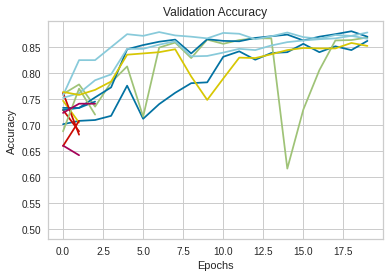

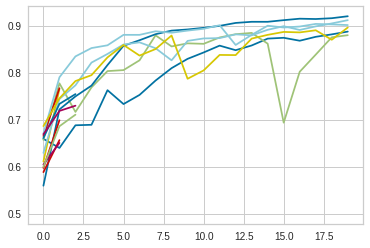

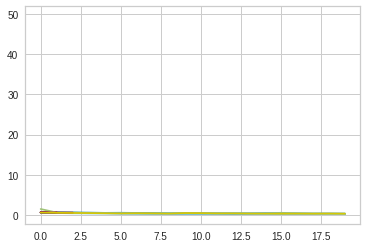

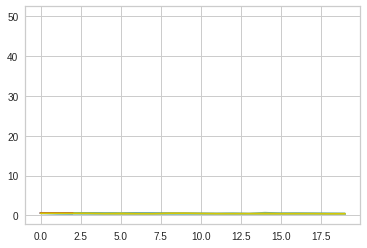

TypeError: ignored

In [ ]:
import matplotlib.pyplot as plt
dfs = dataframe
[d.val_acc.plot() for d in dfs.values()]
plt.title(f'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.savefig('validation_accuracy' + '.png')
plt.show()
[d.train_acc.plot() for d in dfs.values()]
plt.show()
[d.train_loss.plot() for d in dfs.values()]
#plt.ylim([0, 0.5])
plt.show()
[d.mean_loss.plot() for d in dfs.values()]
#plt.ylim([0.3, 0.8])
plt.show()
#print(f'Best config: {analysis[0].get_best_config(metric="val_acc", mode="max")}')
#print(f'Best trial {analysis.get_best_trial(metric="f1_score", mode="min")}')
analysis[0].trials
#current_best_params
#analysis.dataframe().head()


In [ ]:
[d.val_acc.plot() for d in dfs.values()]
plt.title(f'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.savefig('validation_accuracy' + '.png')
plt.show()

In [ ]:
[d.train_acc.plot() for d in dfs.values()]
plt.title(f'Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.savefig('training_accuracy' + '.png')
plt.show()

In [ ]:
[d.train_loss.plot() for d in dfs.values()]
plt.title(f'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.savefig('train_loss' + '.png')
plt.show()

In [ ]:
[d.mean_loss.plot() for d in dfs.values()]
plt.title(f'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.savefig('validation_loss' + '.png')
plt.show()

In [ ]:
print(f'Best config for validation accuracy: {analysis.get_best_config(metric="val_acc", mode="max")} with value: {analysis.get_(metric="val_acc", mode="max")}')
print(f'Best config for validation loss: {analysis.get_best_config(metric="mean_loss", mode="min")}')

print(f'Best config for training accuracy: {analysis.get_best_config(metric="train_acc", mode="max")}')
print(f'Best config for training loss: {analysis.get_best_config(metric="train_loss", mode="min")}')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/tmp/ray/session_2021-05-10_05-41-14_529624_59

In [ ]:
!cat /proc/cpuinfo

In [ ]:
!cd..